# Creating an Amundsen Sea Low (ASL) index

This work is a continuation of my 2013 and 2016 papers as described [here](https://legacy.bas.ac.uk/data/absl/)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skimage.feature import peak_local_max

## Read in gridded monthly mean data for period 1979-2018

In [2]:
ds   = xr.open_dataset('~/Desktop/era5_mean_sea_level_pressure_monthly.nc')
mask = xr.open_dataset('~/Desktop/era5_invariant_lsm.nc').lsm.squeeze()

In [3]:
da = ds.msl

In [4]:
da

<xarray.DataArray 'msl' (time: 480, latitude: 721, longitude: 1440)>
[498355200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 ...
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0 88.75 88.5 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

## Apply land-sea mask

In [5]:
da_mask = da.where(mask == 0)
da_mask.mean().values, da.mean().values # these are different, great!

(array(6675.07617188), array(4412.56201172))

In [6]:
da = da.sel(latitude=slice(-55,-90))

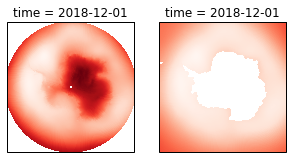

In [7]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da_mask.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )


## Definitions to identify areas of low pressure

In [8]:
def get_lows(da, threshold=None, sigma=None):
    
    import scipy.ndimage as ndimage
    img = ndimage.gaussian_filter(da.values, sigma=sigma)
    da.values = img
    
    invert_data = (da*-1.).values     # search for peaks rather than minima
    
    if threshold is None:
        threshold_abs = invert_data.mean()
    else:
        threshold_abs  = threshold * -1  # define threshold cut-off for peaks (inverted lows)
                
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=1,             # peaks are separated by at least min_distance
                           num_peaks=12,                # maximum number of peaks
                           exclude_border=True,        # excludes peaks from within min_distance - pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    return minima_yx



def sector_mean(da, dict):
    a = da.sel( latitude=slice(asl_region['north'],asl_region['south']), 
                longitude=slice(asl_region['west'],asl_region['east']) ).mean()
    return a



def get_asl(da, region, mask, sigma=11):
    '''
    da for one point in time (with lats x lons)
    '''
    
    lons, lats = da.longitude.values, da.latitude.values
    
    sector_mean_pres = sector_mean(da.where(mask == 0), region).values
    threshold = sector_mean_pres

    time_str = str(da.time.values)[:10]
    
    # fill land in with highest value to limit lows being found here
    da_max   = da.max().values
    da       = da.where(mask == 0).fillna(da_max)
    
    ### get lows for entire domain
    minima_yx = get_lows(da, threshold, sigma)
    
    minima_lat, minima_lon, pressure = [], [], []
    for minima in minima_yx:
        minima_lat.append(lats[minima[0]])
        minima_lon.append(lons[minima[1]])
        pressure.append(da.values[minima[0],minima[1]])
    
    df = pd.DataFrame()
    df['lat']      = minima_lat
    df['lon']      = minima_lon
    df['pressure'] = pressure
    df['ASL_Sector_Pres'] = sector_mean_pres
    df['time']     = time_str
    
    ### select only those points within ASL box
    asl_df = df[(df['lon'] > region['west'])  & 
                (df['lon'] < region['east'])  & 
                (df['lat'] > region['south']) & 
                (df['lat'] < region['north']) ]

    ### For each time, get the row with the lowest minima_number
    asl_df = asl_df.loc[asl_df.groupby('time')['pressure'].idxmin()]
    
    if len(asl_df) == 0:
        print('no asl present', time_str)
        asl_df = pd.DataFrame()
        asl_df['lat']      = [np.nan]
        asl_df['lon']      = [np.nan]
        asl_df['pressure'] = [np.nan]
        asl_df['ASL_Sector_Pres'] = [np.nan]
        asl_df['time']     = [time_str]
    
    asl_df = asl_df[['time','lon','lat','pressure','ASL_Sector_Pres']]
    
    return asl_df

## Define area we are interested in

In [9]:
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

## Loop through all times and identify lows
record these data in a Pandas DataFrame

In [10]:
ntime      = da.time.shape[0]

all_lows_df = pd.DataFrame()
asl_df      = pd.DataFrame()

for t in range(0,ntime):
    da_t   = da.isel(time=t) / 100.
    asl_df = pd.concat([asl_df, get_asl(da_t, asl_region, mask, sigma=11)]).reset_index(drop=True)

no asl present 1981-04-01


### Show the last 7 rows

In [11]:
asl_df

,time,lon,lat,pressure,ASL_Sector_Pres
0,1979-01-01,220.00,-67.75,983.458191,986.254211
1,1979-02-01,196.00,-71.00,975.518982,982.836914
2,1979-03-01,219.50,-68.75,974.010681,980.217896
3,1979-04-01,269.75,-66.50,970.989929,978.922119
4,1979-05-01,189.75,-69.25,978.795471,987.471375
...,...,...,...,...,...
475,2018-08-01,266.00,-65.50,979.433044,986.670349
476,2018-09-01,194.75,-72.50,973.500916,979.564575
477,2018-10-01,209.00,-70.25,967.525940,977.983398
478,2018-11-01,274.50,-67.25,972.007996,978.121460


In [12]:
asl_df.to_csv('asli_v3_era5/asli_v3_era5.csv', index=False)

# Plotting: location of minimas in pressure field

In [13]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

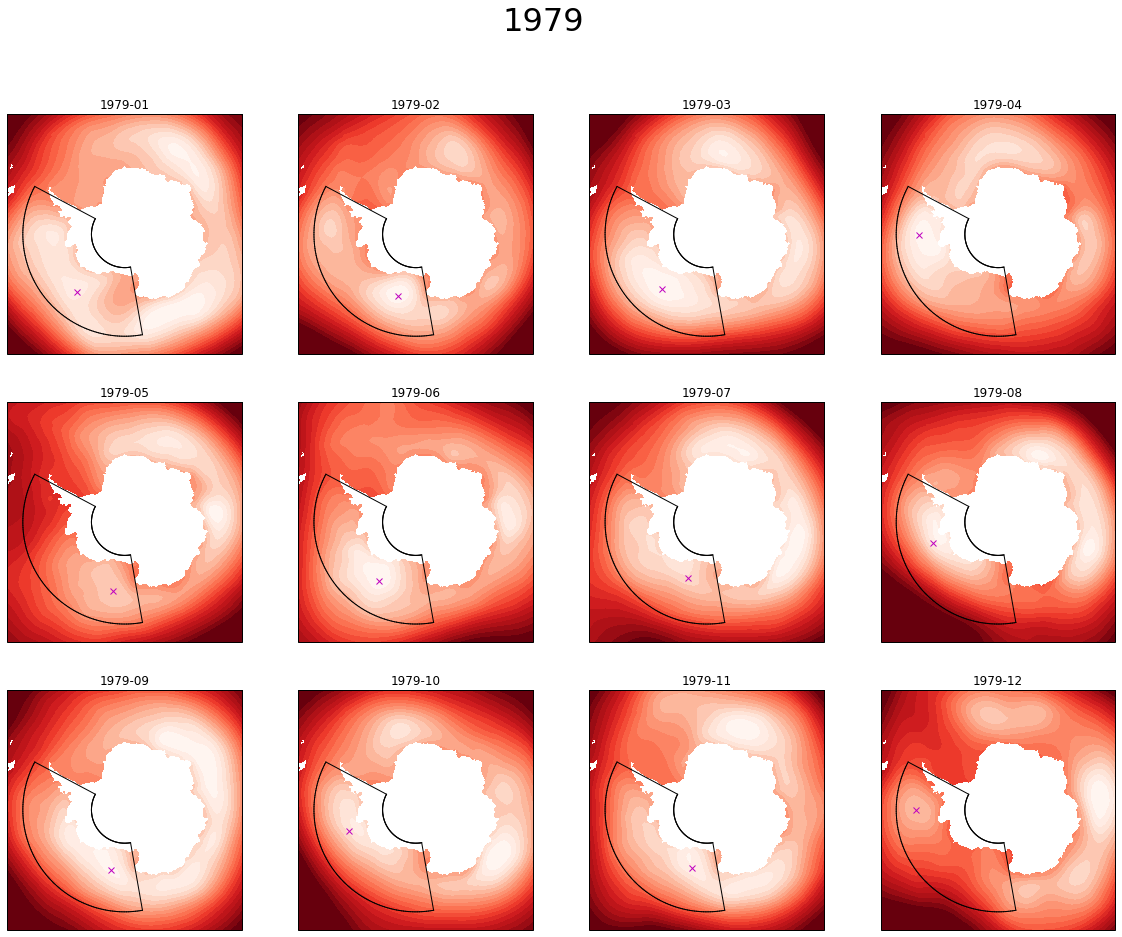

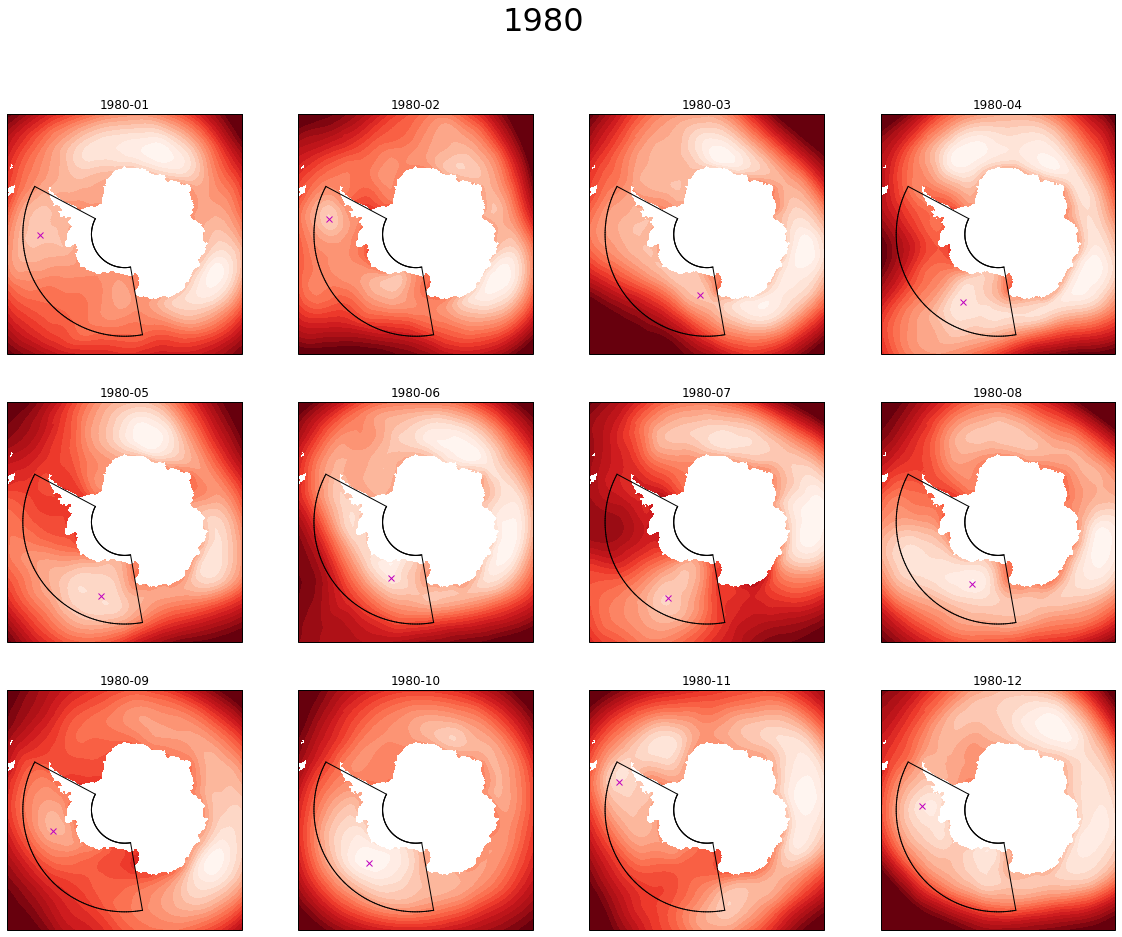

In [19]:
for yr in range(1979,1981):

    plt.figure(figsize=(20,15))

    for i in range(0,12):

        da_2D = da_mask.isel(time=((yr-1979)*12)+i)
        
        plt.suptitle(yr, fontsize=32)
        
        ax = plt.subplot( 3, 4, i+1, 
                            projection=ccrs.Stereographic(central_longitude=0., 
                                                          central_latitude=-90.) )

        ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())

        result = da_2D.plot.contourf( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), 
                                        add_colorbar=False, 
                                        levels=np.linspace(np.nanmin(da_2D.values), np.nanmean(da_2D.values), 20) )

        # ax.coastlines(resolution='110m')
        ax.set_title(str(da_2D.time.values)[0:7])

        ## mark ASL
        df2 = asl_df[ asl_df['time'] == str(da_2D.time.values)[0:10]]
        if len(df2) > 0:
            ax.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )
        draw_regional_box(asl_region)

    plt.savefig('asli_v3_era5/asli_v3_era5_'+str(yr)+'.png', dpi=150)    
    print('')

